In [4]:
# --- CELL 1: IMPORT THƯ VIỆN ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


In [1]:
# --- CELL A: HUẤN LUYỆN MÔ HÌNH TỪ DỮ LIỆU BẠN VỪA TẠO ---
import cv2
import numpy as np
import os

def train_knn_model():
    # Kiểm tra xem file dữ liệu có tồn tại không
    if not os.path.exists("classifications.txt") or not os.path.exists("flattened_images.txt"):
        print("Lỗi: Không tìm thấy file dữ liệu (classifications.txt, flattened_images.txt)!")
        return None

    try:
        # 1. Đọc dữ liệu
        npaClassifications = np.loadtxt("classifications.txt", np.float32)
        npaFlattenedImages = np.loadtxt("flattened_images.txt", np.float32)
        
        # 2. Reshape nhãn
        npaClassifications = npaClassifications.reshape((npaClassifications.size, 1))
        
        # 3. Khởi tạo và huấn luyện KNN
        kNearest = cv2.ml.KNearest_create()
        kNearest.train(npaFlattenedImages, cv2.ml.ROW_SAMPLE, npaClassifications)
        
        print(">>> Huấn luyện thành công! Mô hình đã sẵn sàng nhận diện.")
        return kNearest
        
    except Exception as e:
        print(f"Lỗi khi huấn luyện: {e}")
        return None

# Gọi hàm để tạo model ngay lập tức
knn_model = train_knn_model()

>>> Huấn luyện thành công! Mô hình đã sẵn sàng nhận diện.


In [7]:
# --- CELL 2: BƯỚC 1 - CẮT BIỂN SỐ (LOGIC CANNY THUẦN) ---
def step1_detect_plate(image_path):
    # 1. Đọc ảnh
    img = cv2.imread(image_path)
    if img is None:
        print("Lỗi: Không đọc được ảnh.")
        return None

    # --- TIỀN XỬ LÝ ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Tạo ảnh nhị phân (chỉ để hiển thị)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Canny Edge 
    edged = cv2.Canny(blur, 30, 150)
    
    # --- QUAY LẠI LOGIC CŨ: TÌM CONTOUR TRỰC TIẾP TRÊN CANNY ---
    # Không dùng Morphology Closing nữa để tránh làm dày/dính nét
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    plate_img = None
    found_contour = None
    debug_box = None
    status_text = "Không tìm thấy"
    
    for c in contours:
        rect = cv2.minAreaRect(c)
        (center, (w, h), angle) = rect

        # Chuẩn hóa w, h
        if w < h:
            w, h = h, w
            angle += 90
        if angle > 45: angle -= 90
        elif angle < -45: angle += 90
        
        aspect_ratio = w / float(h)
        area = w * h
        
        # Logic lọc biển số
        if aspect_ratio > 1.8 and aspect_ratio < 6.0 and area > 1500:
            found_contour = c
            
            # Logic xoay ảnh
            if abs(angle) < 30:
                status_text = f"Đã xoay (Góc {int(angle)}°)"
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                rotated_full_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
                
                center_homogeneous = np.array([center[0], center[1], 1.0])
                new_center = M.dot(center_homogeneous)
                new_center = (new_center[0], new_center[1])
                
                plate_img = cv2.getRectSubPix(rotated_full_img, (int(w), int(h)), new_center)
                
                box = cv2.boxPoints(rect)
                debug_box = np.int32(box)
            else:
                status_text = f"Cắt thẳng (Góc {int(angle)}° > 30°)"
                x, y, w_b, h_b = cv2.boundingRect(c)
                plate_img = img[y:y+h_b, x:x+w_b]
                debug_box = np.array([[x,y], [x+w_b, y], [x+w_b, y+h_b], [x, y+h_b]], dtype=np.int32)
            
            break
            
    # --- 3. HIỂN THỊ CHI TIẾT ---
    fig, ax = plt.subplots(2, 3, figsize=(18, 10))
    
    # Hàng 1
    debug_img = img.copy()
    if found_contour is not None:
        cv2.drawContours(debug_img, [found_contour], -1, (0, 255, 0), 2) # Viền xanh
        if debug_box is not None:
            cv2.drawContours(debug_img, [debug_box], 0, (255, 0, 0), 2) # Viền đỏ
            
    ax[0, 0].imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    ax[0, 0].set_title(f"1. Phát hiện: {status_text}")
    
    ax[0, 1].imshow(gray, cmap='gray')
    ax[0, 1].set_title("2. Ảnh Xám")
    
    ax[0, 2].imshow(blur, cmap='gray')
    ax[0, 2].set_title("3. Blur")

    # Hàng 2
    ax[1, 0].imshow(binary, cmap='gray')
    ax[1, 0].set_title("4. Nhị phân")
    
    ax[1, 1].imshow(edged, cmap='gray')
    ax[1, 1].set_title("5. Canny Edges (Logic cũ)")

    if plate_img is not None:
        ax[1, 2].imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
        ax[1, 2].set_title("6. Kết quả")
    else:
        ax[1, 2].text(0.5, 0.5, "Không tìm thấy biển", ha='center', fontsize=12)
        ax[1, 2].set_title("6. Thất bại")

    for row in ax:
        for col in row: col.axis('off')
    plt.tight_layout()
    plt.show()

    if plate_img is None:
        return None
    
    return plate_img

In [23]:
# --- CELL B: BƯỚC 2 - TÁCH & NHẬN DIỆN (CÓ BỘ LỌC CHỐNG NHIỄU) ---
def step2_recognize_characters(plate_img, model):
    if plate_img is None: return

    # 1. Resize & Tiền xử lý
    h_plate, w_plate = plate_img.shape[:2]
    new_h = 60
    new_w = int(new_h * (w_plate / h_plate))
    plate_resized = cv2.resize(plate_img, (new_w, new_h))

    gray = cv2.cvtColor(plate_resized, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # 2. Tìm Contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Danh sách ứng viên thô (chưa lọc kỹ)
    candidates = []

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        aspect_ratio = w / float(h)
        height_ratio = h / float(new_h)
        area = w * h

        # Lọc thô: Bắt tất cả những gì CÓ THỂ là chữ
        if 0.2 < height_ratio < 0.95 and 0.1 < aspect_ratio < 2.0 and area > 50:
            candidates.append((x, y, w, h, c))

    if not candidates:
        print("Không tìm thấy ký tự nào.")
        return

    # --- BỘ LỌC THÔNG MINH (MEDIAN FILTER) ---
    # Mục tiêu: Loại bỏ dấu chấm (.) và gạch ngang (-) dựa trên chiều cao trung bình
    
    # 1. Tính chiều cao trung vị (Median Height) của các ứng viên
    heights = [cand[3] for cand in candidates]
    median_h = np.median(heights)
    
    # 2. Lọc lại: Chỉ giữ những ký tự cao ít nhất 60% so với chiều cao trung vị
    # Ví dụ: Chữ số cao 40px -> Median = 40. Dấu chấm cao 10px -> 10 < 40*0.6 -> LOẠI
    valid_chars = []
    for (x, y, w, h, c) in candidates:
        if h > median_h * 0.6: 
            valid_chars.append((x, y, w, h))
        else:
            # (Tùy chọn) Vẽ màu đỏ lên các phần tử bị loại để debug
            pass 

    # --- NHẬN DIỆN VÀ HIỂN THỊ ---
    
    final_results = []
    
    for (x, y, w, h) in valid_chars:
        roi = binary[y:y+h, x:x+w]
        
        predicted_char = "?"
        if model is not None:
            roi_small = cv2.resize(roi, (20, 30))
            roi_flat = roi_small.reshape((1, 20 * 30)).astype(np.float32)
            
            retval, results, neigh_resp, dists = model.findNearest(roi_flat, k=3)
            predicted_char = str(chr(int(results[0][0])))
        
        final_results.append((x, y, w, h, predicted_char))

    # Sắp xếp từ trái sang phải
    final_results = sorted(final_results, key=lambda k: k[0])
    plate_text = "".join([res[4] for res in final_results])
    
    print(f"Biển số nhận diện: {plate_text}")

    # --- VẼ HÌNH ---
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(binary, cmap='gray')
    ax[0].set_title("Phân đoạn (Adaptive Threshold)")
    
    result_img = plate_resized.copy()
    for (x, y, w, h, char) in final_results:
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result_img, char, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        
    ax[1].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"Kết quả (Đã lọc nhiễu): {plate_text}")
    plt.show()

Đang xử lý: ./LP-characters/images/0010.png


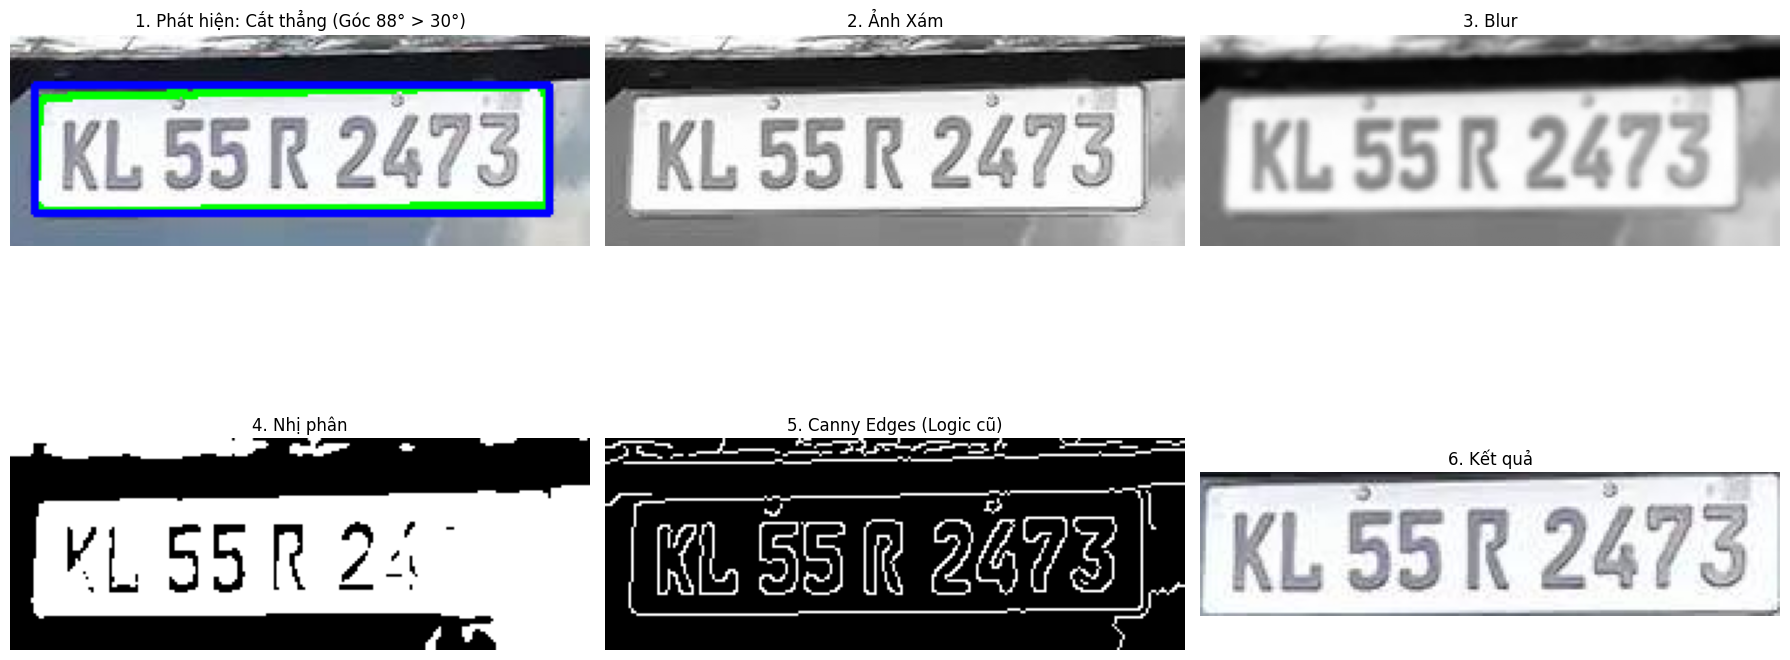

Biển số nhận diện: KL55R2473


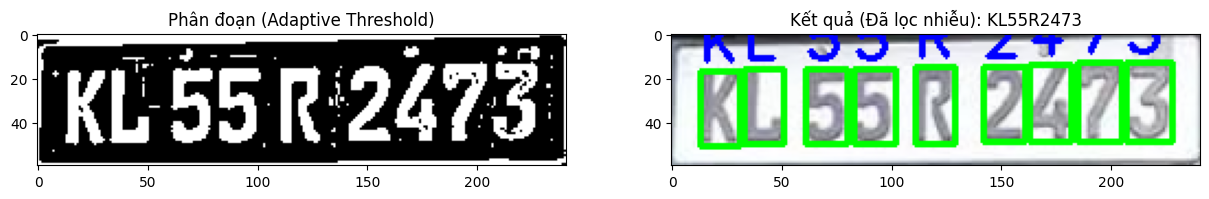

In [26]:
# --- CELL C: CHẠY THỬ NGHIỆM ---

# Thay ảnh của bạn vào đây
image_path = './LP-characters/images/0010.png' 

print(f"Đang xử lý: {image_path}")

# Kiểm tra model
if 'knn_model' not in globals() or knn_model is None:
    print("CẢNH BÁO: Chưa có model KNN. Hãy chạy Cell A trước!")

# Bước 1: Cắt biển
cropped_plate = step1_detect_plate(image_path)

# Bước 2: Nhận diện
if cropped_plate is not None:
    step2_recognize_characters(cropped_plate, knn_model)
else:
    print("Fallback: Dùng ảnh gốc...")
    original = cv2.imread(image_path)
    if original is not None:
        step2_recognize_characters(original, knn_model)